In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [2]:
##lutkepohl2 "https://www.stata-press.com/data/r12"

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #ADF Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error ##MSE

## Import and clean data

In [4]:
data = sm.datasets.webuse('lutkepohl2', "https://www.stata-press.com/data/r12/")

In [5]:
data.index = data.qtr
data.index.freq = data.index.inferred_freq

In [6]:
data.shape

(92, 10)

In [7]:
data.head()

,inv,inc,consump,qtr,ln_inv,dln_inv,ln_inc,dln_inc,ln_consump,dln_consump
qtr,,,,,,,,,,
1960-01-01,180,451,415,1960-01-01,5.192957,NaN,6.111467,NaN,6.028278,NaN
1960-04-01,179,465,421,1960-04-01,5.187386,-0.005571,6.142037,0.030570,6.042633,0.014355
1960-07-01,185,485,434,1960-07-01,5.220356,0.032970,6.184149,0.042111,6.073044,0.030411
1960-10-01,192,493,448,1960-10-01,5.257495,0.037139,6.200509,0.016360,6.104793,0.031749
1961-01-01,211,509,459,1961-01-01,5.351858,0.094363,6.232448,0.031939,6.129050,0.024257


In [8]:
data.tail()

,inv,inc,consump,qtr,ln_inv,dln_inv,ln_inc,dln_inc,ln_consump,dln_consump
qtr,,,,,,,,,,
1981-10-01,830,2620,2225,1981-10-01,6.721426,-0.047068,7.870930,0.015385,7.707512,0.008576
1982-01-01,801,2639,2235,1982-01-01,6.685861,-0.035564,7.878155,0.007226,7.711997,0.004484
1982-04-01,824,2618,2237,1982-04-01,6.714170,0.028309,7.870166,-0.007989,7.712891,0.000895
1982-07-01,831,2628,2250,1982-07-01,6.722630,0.008460,7.873979,0.003813,7.718686,0.005795
1982-10-01,830,2651,2271,1982-10-01,6.721426,-0.001204,7.882692,0.008714,7.727975,0.009290


In [9]:
train = data.loc['1960-04-01':'1978-10-01'] ##75 quarters
test = data.loc['1979-01-01':] ##16 quarters

In [10]:
train.shape

(75, 10)

In [11]:
test.shape

(16, 10)

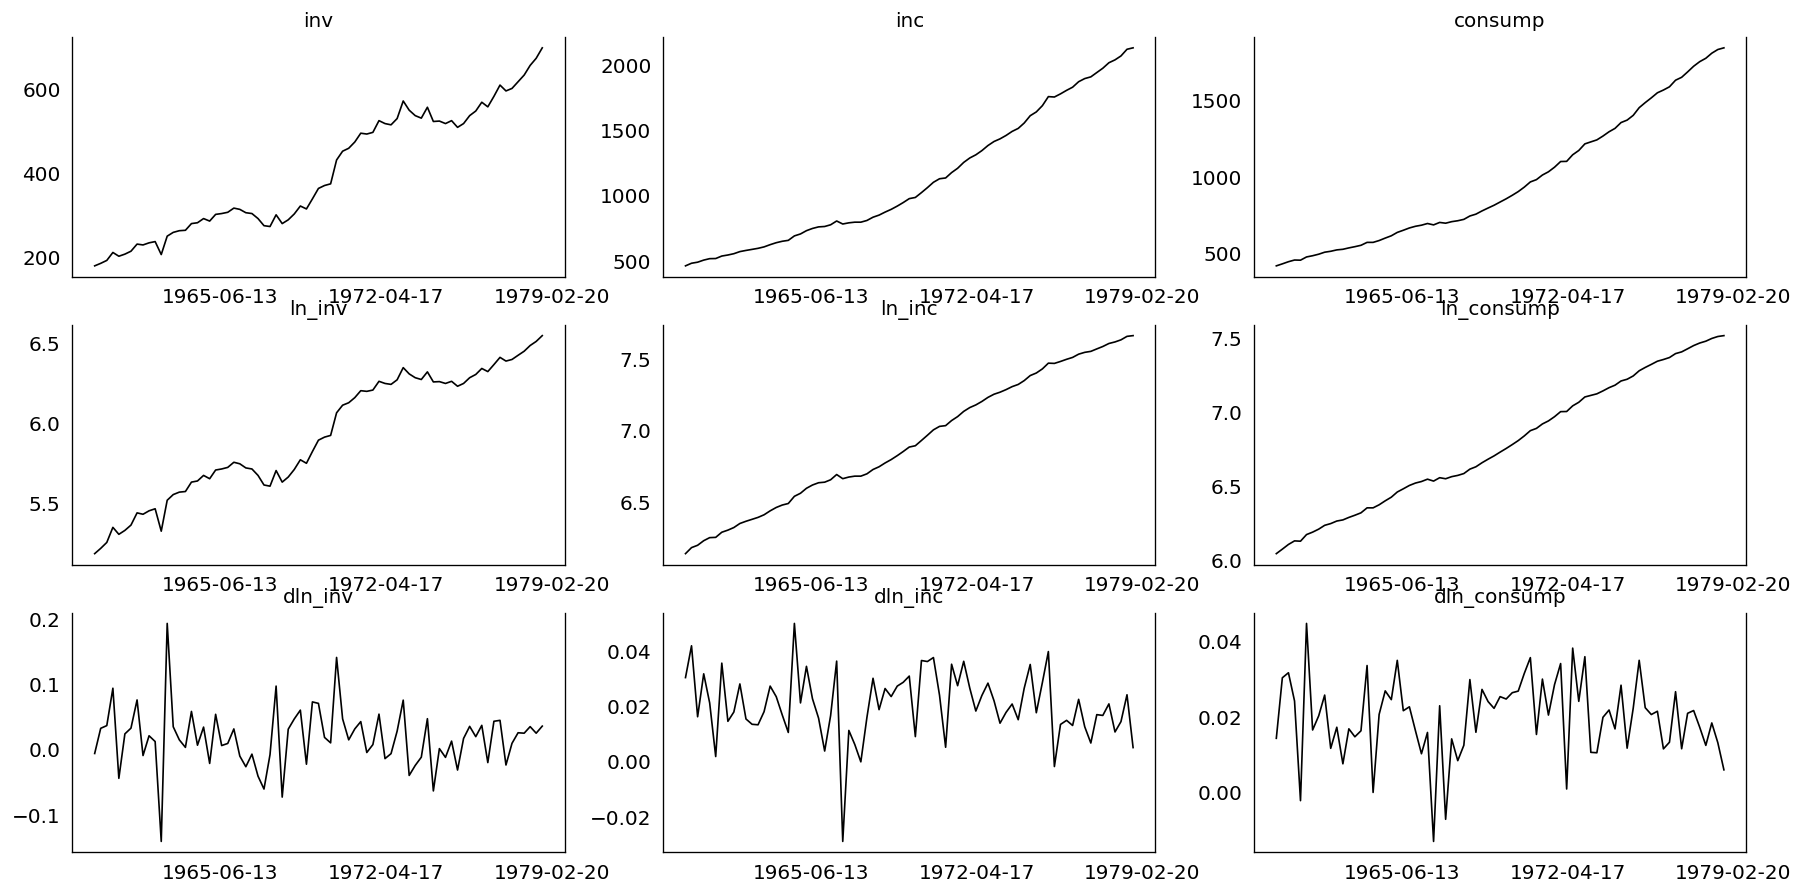

In [12]:
##plot the data visualization
ls = ['inv','inc','consump','ln_inv','ln_inc','ln_consump', 'dln_inv','dln_inc','dln_consump']
df = train[ls]
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(18,9))
for i, ax in enumerate(axes.flatten()):
  ax.plot(df[df.columns[i]], color='black', linewidth=1)
  ax.xaxis.set_major_locator(plt.MaxNLocator(3))
  ax.set_title(df.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize=12)

## Stationary Test - ADF at 5% significance

In [13]:
for i in range(len(ls)):
  print('\n\n'+ls[i]+' : ADF Test Results')
  result = adfuller(train[ls[i]])
  print('ADF Statistics: %f ' %result[0])
  print('p-value: %f ' %result[1])
  print('Critical Values: ')
  for key, value in result[4].items():
    if key=='5%':
      print('\t%s: %.3f '%(key, value))



inv : ADF Test Results
ADF Statistics: 0.238053 
p-value: 0.974317 
Critical Values: 
	5%: -2.904 


inc : ADF Test Results
ADF Statistics: 4.956163 
p-value: 1.000000 
Critical Values: 
	5%: -2.901 


consump : ADF Test Results
ADF Statistics: 1.757540 
p-value: 0.998261 
Critical Values: 
	5%: -2.903 


ln_inv : ADF Test Results
ADF Statistics: -0.678588 
p-value: 0.852218 
Critical Values: 
	5%: -2.904 


ln_inc : ADF Test Results
ADF Statistics: -0.815066 
p-value: 0.814656 
Critical Values: 
	5%: -2.901 


ln_consump : ADF Test Results
ADF Statistics: 0.090957 
p-value: 0.965438 
Critical Values: 
	5%: -2.903 


dln_inv : ADF Test Results
ADF Statistics: -2.766930 
p-value: 0.063155 
Critical Values: 
	5%: -2.904 


dln_inc : ADF Test Results
ADF Statistics: -8.166436 
p-value: 0.000000 
Critical Values: 
	5%: -2.901 


dln_consump : ADF Test Results
ADF Statistics: -3.152453 
p-value: 0.022907 
Critical Values: 
	5%: -2.903 


### VAR Model

In [14]:
exog = train["dln_consump"]
mod = sm.tsa.VARMAX(train[['dln_inv','dln_inc']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                             VAR(1)   Log Likelihood                 333.024
Date:                    Thu, 08 Jul 2021   AIC                           -652.049
Time:                            14:58:54   BIC                           -635.826
Sample:                        04-01-1960   HQIC                          -645.571
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                66.67, 63.88   Jarque-Bera (JB):         12.21, 13.05
Prob(Q):                        0.01, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.39, 0.65   Skew:                      0.14, -0.46
Prob(H) (two-sided):            0.02, 0.30   Kurtosis:                   4.96, 4.83


## Model Performance - VAR

In [15]:
start_index = test.index.min()
end_index = test.index.max()
predictions = mod.fit().predict(start=start_index, end=end_index)

for i in range(predictions.shape[0]):
    if i==0:
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inv']=train.iloc[74,4]
        predictions.loc[predictions.index=='1979-01-01','lag_ln_inc']=train.iloc[74,6]
    else:
        predictions.iloc[i,2]=predictions.iloc[i-1,4]
        predictions.iloc[i,3]=predictions.iloc[i-1,5]

    predictions['ln_inv']=(predictions['lag_ln_inv']+predictions['dln_inv'])
    predictions['ln_inc']=(predictions['lag_ln_inc']+predictions['dln_inc'])


    predictions['inv']=np.exp(predictions['ln_inv'])
    predictions['inc']=np.exp(predictions['ln_inc'])

In [16]:
predictions.head()

,dln_inv,dln_inc,lag_ln_inv,lag_ln_inc,ln_inv,ln_inc,inv,inc
1979-01-01,-0.002454,0.006037,6.551080,7.664816,6.548626,7.670852,698.284137,2144.909120
1979-04-01,0.005990,0.004068,6.548626,7.670852,6.554616,7.674920,702.479494,2153.652306
1979-07-01,0.002529,0.003248,6.554616,7.674920,6.557145,7.678169,704.258414,2160.659112
1979-10-01,0.002464,0.002444,6.557145,7.678169,6.559609,7.680613,705.995815,2165.946547
1980-01-01,0.001743,0.001876,6.559609,7.680613,6.561353,7.682489,707.227751,2170.014404


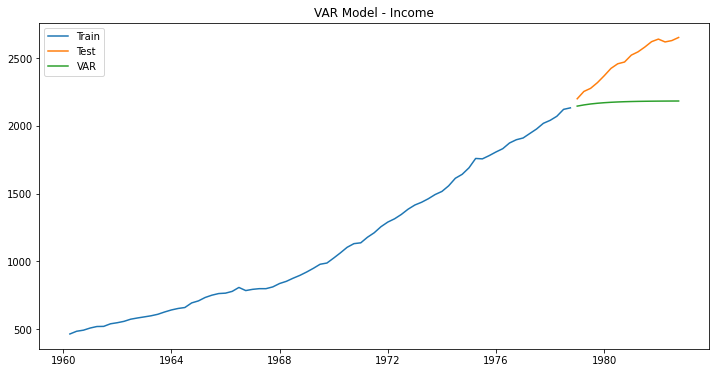

In [17]:
plt.figure(figsize=(12,6)) 
plt.plot( train['inc'], label='Train')
plt.plot(test['inc'], label='Test')
plt.plot(predictions['inc'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

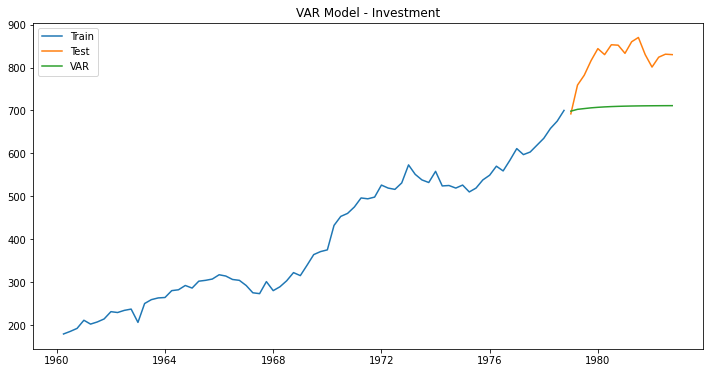

In [18]:
plt.figure(figsize=(12,6))
plt.plot(train['inv'], label='Train')
plt.plot(test['inv'], label='Test')
plt.plot(predictions['inv'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Investment')
plt.show()

In [22]:
### Root Mean Squared Error - Income
rmse = np.sqrt(mean_squared_error(test.inc, predictions.inc)).round(2)
model_comparison = pd.DataFrame()
model_comparison.loc[0,'Model'] = 'VAR'
model_comparison.loc[0,'Variable'] = 'Income'
model_comparison.loc[0,'RMSE'] = rmse

### Root Mean Squared Error - Investment
rmse = np.sqrt(mean_squared_error(test.inv, predictions.inv)).round(2)
append = pd.DataFrame()
append.loc[0,'Model'] = 'VAR'
append.loc[0,'Variable'] = 'Investment'
append.loc[0,'RMSE'] = rmse
model_comparison = model_comparison.append(append)

In [23]:
model_comparison

,Model,Variable,RMSE
0,VAR,Income,329.41
0,VAR,Investment,117.97


In [24]:
##Mean Absolute Percentage Error
abs_error = np.abs(test.inc-predictions.inc)
actual=test.inc
mape = np.round(np.mean(abs_error/actual)*100,2)

model_comparison.loc[model_comparison['Variable']=='Income', 'MAPE'] = mape

##Mean Absolute Percentage Error
abs_error = np.abs(test.inv-predictions.inv)
actual=test.inv
mape = np.round(np.mean(abs_error/actual)*100,2)

model_comparison.loc[model_comparison['Variable']=='Investment', 'MAPE'] = mape

model_comparison

,Model,Variable,RMSE,MAPE
0,VAR,Income,329.41,11.83
0,VAR,Investment,117.97,13.43
